# Experiment 3: a new training scheme

## Settings

In [27]:
python_modules_path = '/Users/yangzhihan/code/python_modules/'
notebook_name = 'new-training-scheme.ipynb'

# settings
csv_save_path = '/Users/yangzhihan/Desktop/dann/training_csvs/new_training_scheme'
pth_save_path = '/Users/yangzhihan/Desktop/dann/trained_models/new_training_scheme'

## Imports

In [28]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
import sys
sys.path.insert(0, python_modules_path)
from path_magic import path_magic

import os
path_magic.make_dir_importable_relative(current_fname=os.path.realpath(notebook_name), 
                                        nup=1,
                                        target_dir_name='model_defs',
                                        show=True,
                                        show_with_suffix='py')
path_magic.make_dir_importable_relative(current_fname=os.path.realpath(notebook_name), 
                                        nup=1,
                                        target_dir_name='scripts',
                                        show=True,
                                        show_with_suffix='py')

Message: /Users/yangzhihan/Desktop/dann/experiments/../model_defs added to sys.path
Contains: ['exp1.py', 'exp3.py']
Message: /Users/yangzhihan/Desktop/dann/experiments/../scripts added to sys.path
Contains: ['create_mnistm.py', 'utils.py', 'default_path.py', 'load_data.py', 'flip_gradient.py']


In [30]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# standard imports for pytorch
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from exp3 import FeatureExtractor, LabelClassifier, Dis  # import model classes
from load_data import load_data_org, edge_detect  # import functions for getting and preprocessing data
from ndarray_info.ndarray_info import get_info

## Define model

In [31]:
feature_extractor = FeatureExtractor()

========== Model Summary ==========
* Input shape: (3, 28, 28) -> Conv2d -> Output shape:  (32, 26, 26)
* Input shape: (32, 26, 26) -> MaxPool2d -> Output shape:  (32, 13, 13)
* Input shape: (32, 13, 13) -> Conv2d -> Output shape:  (64, 11, 11)
* Input shape: (64, 11, 11) -> MaxPool2d -> Output shape:  (64, 5, 5)
* Input shape: (64, 5, 5) -> Conv2d -> Output shape:  (64, 3, 3)


In [32]:
label_classifier = LabelClassifier()

========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 10


In [33]:
def get_models(lr=0.01):
    """Return models and their corresponding optimizers."""
    
    fe = FeatureExtractor().double()
    fe_opt = optim.SGD(fe.parameters(), lr=lr, momentum=0.9)
    
    lc = LabelClassifier().double()
    lc_opt = optim.SGD(lc.parameters(), lr=lr, momentum=0.9)
    
    dis = Dis().double()
    dis_opt = optim.SGD(dis.parameters(), lr=lr, momentum=0.9)
    
    return (fe, fe_opt), (lc, lc_opt), (dis, dis_opt)


## Load data

In [34]:
mnist_path = '../data/MNIST_data'
mnistm_path = '../data/mnistm_data.pkl'

In [35]:
(mnist_train, mnist_train_labels), (mnist_test, mnist_test_labels), (mnistm_train, mnistm_test), (combined_test_imgs, combined_test_labels, combined_test_domain) = load_data_org(mnist_path, mnistm_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [36]:
info = get_info(shape=True, dtype=True, mean=True, min=True, max=True)

In [37]:
for array in [mnist_train, 
              mnist_train_labels, 
              mnistm_train,
              mnist_test, 
              mnist_test_labels,
              mnistm_test, 
              combined_test_imgs,
              combined_test_labels, 
              combined_test_domain]:
    info(array)

Array Summary:
* Shape: (55000, 3, 28, 28)
* dtype: float64
* Mean: -0.12921006657207923
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (55000,)
* dtype: int64
* Mean: 4.452745454545455
* Max: 9
* Min: 0
Array Summary:
* Shape: (55000, 3, 28, 28)
* dtype: float64
* Mean: 0.1292100665720834
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (10000, 3, 28, 28)
* dtype: float64
* Mean: -0.1276862377223613
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (10000,)
* dtype: int64
* Mean: 4.4434
* Max: 9
* Min: 0
Array Summary:
* Shape: (10000, 3, 28, 28)
* dtype: float64
* Mean: 0.1308327517067431
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (1000, 3, 28, 28)
* dtype: float64
* Mean: -0.008705471249105723
* Max: 0.6947281977791117
* Min: -0.328982357306559
Array Summary:
* Shape: (1000,)
* dtype: int64
* Mean: 4.378
* Max: 9
* Min: 0
Array Summary:
* Shape: (1000,)
* dtype: int64
*

## Define training loop function

### Metrics

In [128]:
loss_func = F.cross_entropy

In [46]:
def accuracy(logits : torch.DoubleTensor, truth : torch.LongTensor):
    preds = torch.argmax(logits, dim=1)
    return (preds == truth).float().mean()

### Class for accummulating metric values

In [24]:
class MetricAccumulator:
    
    def __init__(self, nmetric=1):
        self.metrics = [[] for i in range(nmetric)]
        
    def accumulate(self, values):
        for i, value in enumerate(values):
            self.metrics[i].append(value)
            
    def output(self):
        return self.metrics

### Functions for saving metric values as csvs and models as pths

In [157]:
def save_metrics_as_csv(metrics, metric_names, save_path, save_name):
    """
    Save a list of list of metric values (recorded during training) as one csv file.
    
    metrics: a list of list of metric values, e.g. [[1, 2, 3], [7.8, 5.6, 3.4], [50.0, 71.7, 99.9]]
    metric_names: corresponding names of metrics, e.g. ['epoch', 'loss', 'acc']
    param: save_path: e.g. "/Users/username/project_name/training_csvs"
    param: save_name: e.g. "vgg16_training.csv"
    """
    loss_df = pd.DataFrame(np.array(list(zip(*metrics))))
    loss_df.columns = metric_names
    loss_df.to_csv(os.path.join(save_path, save_name))
    print('{} is saved at {}.'.format(save_name, save_path))

In [158]:
def save_model_as_pth(model, save_path, save_name):
    """
    Save weights of a PyTorch model as a pth file.
    
    param: model: e.g. a convolutional neural network
    param: save_path: e.g. "/Users/username/project_name/trained_models"
    param: save_name: e.g. "vgg16.pth"
    """
    torch.save(model.state_dict(), os.path.join(save_path, save_name))
    print('{} is saved at {}.'.format(save_name, save_path))

### Sampling function

In [135]:
def random_sample(data, labels, batch_size, return_numpy=False):
    """
    Randomly sample a fixed number of data and labels.
    
    param: data: e.g. images
    param: labels: e.g. image classes
    param: batch_size
    param: return_numpy: whether to return 
        (data_batch, label_batch), (data_tensor, label_tensor) or
        (data_tensor, label_tensor)
    """
    indices = np.random.randint(data.shape[0], size=batch_size)  # generate random indices
    data_batch, label_batch = mnist_train[indices], mnist_train_labels[indices]
    data_tensor, label_tensor = torch.from_numpy(data_batch).double(), torch.from_numpy(label_batch).long()
    
    if return_numpy:
        return (data_batch, label_batch), (data_tensor, label_tensor)
    else:
        return (data_tensor, label_tensor)

### Function for getting different data with the same label or different labels

In [140]:
def get_data_same_labels(label_batch, all_labels, all_data):
    new_data = []
    for label in label_batch:
        indices_of_same_label = np.where(all_labels == label)[0]
        index_of_same_label = np.random.choice(indices_of_same_label)
        new_data.append(all_data[index_of_same_label])
    new_data = np.array(new_data)
    new_data = torch.from_numpy(new_data)
    return new_data

In [141]:
def get_data_different_labels(label_batch, all_labels, all_data):
    new_data = []
    for label in label_batch:
        indices_of_same_label = np.where(all_labels != label)[0]
        index_of_same_label = np.random.choice(indices_of_same_label)
        new_data.append(all_data[index_of_same_label])
    new_data = np.array(new_data)
    new_data = torch.from_numpy(new_data)
    return new_data

### Training loop

In [154]:
def train(mode='basic'):
    
    if mode == 'basic':
    
        nepoch = 3
        steps_per_epoch = 860
        bs = 64
        
        (fe, fe_opt), (lc, lc_opt), (_, _) = get_models(lr=0.01)
        accum_train = MetricAccumulator(nmetric=5)  # step, loss, acc, fw-loss-wc, fw-loss-ac 
        accum_valid = MetricAccumulator(nmetric=3)

        print('========== Training ========')
        
        for i in range(nepoch):
        
            fe.train(); lc.train()  # training mode
            for j in range(steps_per_epoch):

                (data_batch, label_batch), (data_tensor, label_tensor) = random_sample(mnist_train, mnist_train_labels, 64, return_numpy=True)  # get data
                feats = fe(data_tensor); preds = lc(feats)  # feed-forward
                loss = loss_func(preds, label_tensor)  # compute metric: loss
                loss.backward()  # compute gradients
                
                # gradient descent and clear gradients
                fe_opt.step(); fe_opt.zero_grad()  
                lc_opt.step(); lc_opt.zero_grad()
                
                # evaluate metrics
                if j % 10 == 0: 
                    
                    # compute metric: acc
                    acc = accuracy(preds, label_tensor)
                    
                    ##### for mnist #####
                    
                    # debug: 
                    # - get_data_different_labels
                    # - mnistm_train
                    # - featurewise_loss_ac
                    
                    # compute metric: featurewise-loss (within class) for mnist
                    new_data = get_data_same_labels(label_batch, mnist_train_labels, mnist_train)
                    feats_new = fe(new_data)
                    featurewise_loss_wc = ((feats_new - feats)**2).mean()
                    
                    # compute metric: featurewise-loss (among classes) for mnist
                    new_data = get_data_different_labels(label_batch, mnist_train_labels, mnist_train)
                    feats_new = fe(new_data)
                    featurewise_loss_ac = ((feats_new - feats)**2).mean()
                    
                    # accumulate metric values
                    accum_train.accumulate([i * steps_per_epoch + j, 
                                            loss.detach().item(), 
                                            acc.detach().item(),
                                            featurewise_loss_wc.detach().item(),
                                            featurewise_loss_ac.detach().item()])
                    
                    print('epoch {0:2}/10 {1:3} | acc: {2:5.3f} | MNIST fw-loss-wc {3:6.3f} fw-loss-ac {4:6.3f}'.format(i, j, acc.item(), featurewise_loss_wc.item(), featurewise_loss_ac.item()))
                    
            ##########
                    
            fe.eval(); lc.eval()  # validation mode
                
            data_entire, label_entire = torch.from_numpy(mnist_test).double(), torch.from_numpy(mnist_test_labels).long()

            # feed-forward
            feats = fe(data_entire)
            preds = lc(feats)

            # compute metrics
            loss = loss_func(preds, label_entire)
            acc = accuracy(preds, label_entire)

            # accumulate metric values
            accum_valid.accumulate([(i + 1) * steps_per_epoch, 
                                    loss.detach().item(), 
                                    acc.detach().item()])

            print('[Validation] Label loss: {0:3.3f} | Accuracy: {1:5.3f}'.format(loss.item(), acc.item()))
                   
            ##########

        save_metrics_as_csv(accum_train.output(), ['step', 'loss', 'acc', 'fw_loss_wc', 'fw_loss_ac'], csv_save_path, f'{mode}_train.csv')
        save_metrics_as_csv(accum_valid.output(), ['step', 'loss', 'acc'], csv_save_path, f'{mode}_valid.csv')
 
        save_model_as_pth(fe, pth_save_path, f'{mode}_fe.pth')
        save_model_as_pth(lc, pth_save_path, f'{mode}_lc.pth')

In [155]:
train('basic')

========== Model Summary ==========
* Input shape: (3, 28, 28) -> Conv2d -> Output shape:  (32, 26, 26)
* Input shape: (32, 26, 26) -> MaxPool2d -> Output shape:  (32, 13, 13)
* Input shape: (32, 13, 13) -> Conv2d -> Output shape:  (64, 11, 11)
* Input shape: (64, 11, 11) -> MaxPool2d -> Output shape:  (64, 5, 5)
* Input shape: (64, 5, 5) -> Conv2d -> Output shape:  (64, 3, 3)
========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 10
========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 2
========== Training ========
epoch  0/10   0 | acc: 0.156 | MNIST fw-loss-wc  0.001 fw-loss-ac  0.002
epoch  0/10  10 | acc: 0.062 | MNIST fw-loss-wc  0.001 fw-loss-ac  0.002
epoch  0/10  20 | acc: 0.109 | MNIST fw-loss-wc  0.001 fw-loss-ac  0.002
epoch  0/10  30 | acc: 0.234 | MNIST fw-loss-wc  0.002 fw-loss-ac  0.003
epoch  0/10  40 | acc: 0.297 | MNI

epoch  1/10 170 | acc: 0.969 | MNIST fw-loss-wc  1.153 fw-loss-ac  2.162
epoch  1/10 180 | acc: 0.969 | MNIST fw-loss-wc  1.247 fw-loss-ac  2.148
epoch  1/10 190 | acc: 1.000 | MNIST fw-loss-wc  1.151 fw-loss-ac  1.921
epoch  1/10 200 | acc: 0.969 | MNIST fw-loss-wc  0.992 fw-loss-ac  1.816
epoch  1/10 210 | acc: 0.984 | MNIST fw-loss-wc  1.201 fw-loss-ac  2.114
epoch  1/10 220 | acc: 0.984 | MNIST fw-loss-wc  1.123 fw-loss-ac  2.162
epoch  1/10 230 | acc: 0.984 | MNIST fw-loss-wc  1.147 fw-loss-ac  2.075
epoch  1/10 240 | acc: 0.953 | MNIST fw-loss-wc  1.076 fw-loss-ac  2.091
epoch  1/10 250 | acc: 0.984 | MNIST fw-loss-wc  1.202 fw-loss-ac  2.261
epoch  1/10 260 | acc: 0.938 | MNIST fw-loss-wc  1.148 fw-loss-ac  2.249
epoch  1/10 270 | acc: 0.953 | MNIST fw-loss-wc  1.118 fw-loss-ac  1.883
epoch  1/10 280 | acc: 0.984 | MNIST fw-loss-wc  0.970 fw-loss-ac  1.938
epoch  1/10 290 | acc: 0.984 | MNIST fw-loss-wc  1.135 fw-loss-ac  1.918
epoch  1/10 300 | acc: 0.953 | MNIST fw-loss-wc  1.

epoch  2/10 430 | acc: 0.984 | MNIST fw-loss-wc  1.275 fw-loss-ac  2.356
epoch  2/10 440 | acc: 0.938 | MNIST fw-loss-wc  1.332 fw-loss-ac  2.432
epoch  2/10 450 | acc: 1.000 | MNIST fw-loss-wc  1.227 fw-loss-ac  2.249
epoch  2/10 460 | acc: 1.000 | MNIST fw-loss-wc  1.345 fw-loss-ac  2.211
epoch  2/10 470 | acc: 0.984 | MNIST fw-loss-wc  1.278 fw-loss-ac  2.257
epoch  2/10 480 | acc: 1.000 | MNIST fw-loss-wc  1.210 fw-loss-ac  2.361
epoch  2/10 490 | acc: 0.969 | MNIST fw-loss-wc  1.186 fw-loss-ac  2.275
epoch  2/10 500 | acc: 0.969 | MNIST fw-loss-wc  1.173 fw-loss-ac  2.142
epoch  2/10 510 | acc: 1.000 | MNIST fw-loss-wc  1.023 fw-loss-ac  1.943
epoch  2/10 520 | acc: 1.000 | MNIST fw-loss-wc  1.012 fw-loss-ac  1.845
epoch  2/10 530 | acc: 0.969 | MNIST fw-loss-wc  1.156 fw-loss-ac  1.958
epoch  2/10 540 | acc: 0.969 | MNIST fw-loss-wc  1.148 fw-loss-ac  2.159
epoch  2/10 550 | acc: 0.969 | MNIST fw-loss-wc  1.210 fw-loss-ac  2.244
epoch  2/10 560 | acc: 1.000 | MNIST fw-loss-wc  1.

## Inference on MNIST-M

In [38]:
def load_fe(save_path, save_name, device='cpu'):
    model = FeatureExtractor().to(device)
    model.load_state_dict(torch.load(os.path.join(save_path, save_name), map_location=device))
    return model.double()

In [39]:
def load_lc(save_path, save_name, device='cpu'):
    model = LabelClassifier().to(device)
    model.load_state_dict(torch.load(os.path.join(save_path, save_name), map_location=device))
    return model.double()

In [40]:
fe_basic = load_fe(pth_save_path, 'basic_fe.pth')

========== Model Summary ==========
* Input shape: (3, 28, 28) -> Conv2d -> Output shape:  (32, 26, 26)
* Input shape: (32, 26, 26) -> MaxPool2d -> Output shape:  (32, 13, 13)
* Input shape: (32, 13, 13) -> Conv2d -> Output shape:  (64, 11, 11)
* Input shape: (64, 11, 11) -> MaxPool2d -> Output shape:  (64, 5, 5)
* Input shape: (64, 5, 5) -> Conv2d -> Output shape:  (64, 3, 3)


In [41]:
lc_basic = load_lc(pth_save_path, 'basic_lc.pth')

========== Model Summary ==========
* Input shape: 576 -> Linear -> Output shape: 64
* Input shape: 64 -> Linear -> Output shape: 10


In [57]:
def inference(fe, lc, data, labels):
    
    test_ds = TensorDataset(torch.from_numpy(data).double(), torch.from_numpy(labels).long())
    test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)
    # random shuffle & sample => random sample
    
    # feed-forward
    fe.eval(); lc.eval()
    accs = []
    for data, labels in test_dl: 
        feats = fe(data)
        preds = lc(feats)
        acc = accuracy(preds, labels).detach().item()  # compute metric
        accs.append(acc)
    
    return np.mean(accs)

In [58]:
mnist_test_acc = inference(fe_basic, lc_basic, mnist_test, mnist_test_labels)
print('Inference accuracy is {0:4.2f}% on MNIST test.'.format(mnist_test_acc * 100))

Inference accuracy is 98.56% on MNIST test.


In [59]:
mnistm_test_acc = inference(fe_basic, lc_basic, mnistm_test, mnist_test_labels)
print('Inference accuracy is {0:4.2f}% on MNIST-M test.'.format(mnistm_test_acc * 100))

Inference accuracy is 59.93% on MNIST-M test.


## Trend of `fw-loss`

In [60]:
training_csv = pd.read_csv(os.path.join(csv_save_path, 'basic_train.csv'))

In [61]:
training_csv.head()

,Unnamed: 0,step,loss,acc,fw_loss_wc,fw_loss_ac
0,0,0.0,2.300528,0.156250,0.001215,0.001570
1,1,10.0,2.306125,0.062500,0.001197,0.001849
2,2,20.0,2.289416,0.109375,0.001313,0.002035
3,3,30.0,2.282065,0.234375,0.001895,0.002681
4,4,40.0,2.273516,0.296875,0.002230,0.004257


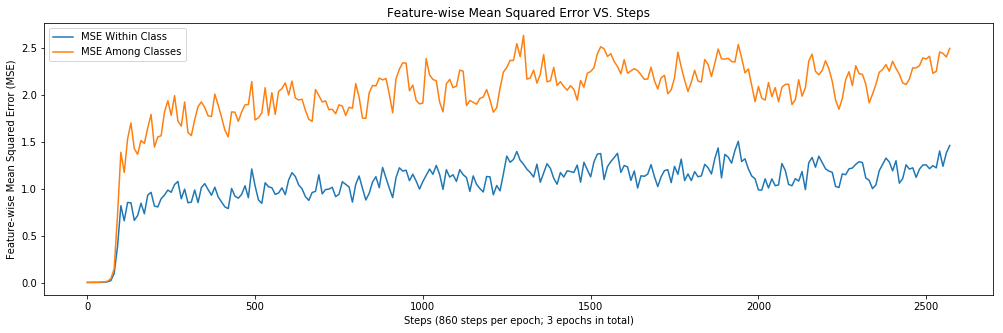

In [62]:
plt.figure(figsize=(17, 5))
steps = np.arange(0, 2580, 10)
plt.plot(steps, training_csv['fw_loss_wc'], label='MSE Within Class')
plt.plot(steps, training_csv['fw_loss_ac'], label='MSE Among Classes')
plt.legend()
plt.xlabel('Steps (860 steps per epoch; 3 epochs in total)')
plt.ylabel('Feature-wise Mean Squared Error (MSE)')
plt.title('Feature-wise Mean Squared Error VS. Steps')
plt.show()

In [63]:
np.mean(training_csv['fw_loss_ac'] / training_csv['fw_loss_wc'])

1.8711994251709014

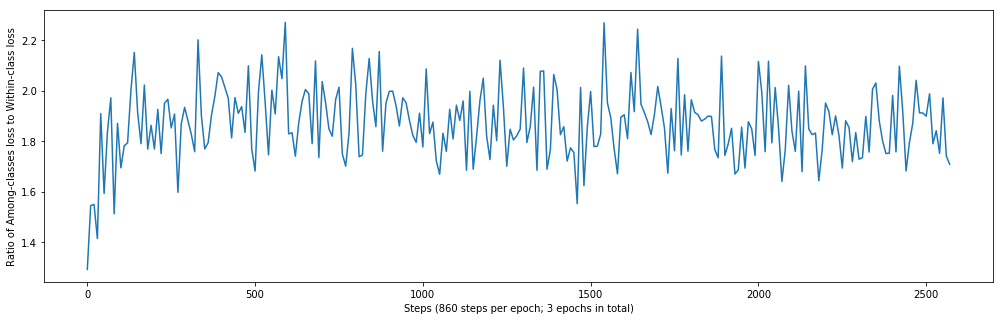

In [14]:
plt.figure(figsize=(17, 5))
plt.plot(steps, training_csv['fw_loss_ac'] / training_csv['fw_loss_wc'])
plt.xlabel('Steps (860 steps per epoch; 3 epochs in total)')
plt.ylabel('Ratio of Among-classes loss to Within-class loss')
plt.show()